Imports


In [ ]:
import os
import pickle
import pathlib
import librosa
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sys import getsizeof
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

# Dataset

In [ ]:
data_dir = pathlib.Path('/content/drive/My Drive/Academics/Fall 2020/Intelligent Systems/Final Project/genres')

In [ ]:
genres = np.array(tf.io.gfile.listdir(str(data_dir)))
print(genres)

['hiphop' 'rock' 'classical' 'country' 'jazz' 'pop' 'reggae' 'disco'
 'metal' 'blues']


In [ ]:
filenames = tf.io.gfile.glob(str(data_dir) + "/*/*")
np.random.shuffle(filenames)
print("Number of total samples: ", len(filenames))
print("Number of samples per label: ", len(tf.io.gfile.listdir(str(data_dir/genres[0]))))
print("Sample file tensor: ", filenames[0])

Number of total samples:  1000
Number of samples per label:  100
Sample file tensor:  /content/drive/My Drive/Academics/Fall 2020/Intelligent Systems/Final Project/genres/reggae/reggae.00034.wav


In [ ]:
def get_max_length(arr):
  max = 0
  for i in arr:
    if len(i) > max:
      max = len(i)
  return max
#MAX_LENGTH = get_max_length(X)

In [ ]:
INPUT_SHAPE = (500, 1025, 1320)
MAX_LENGTH = 675808

In [ ]:
def get_features_and_target(file_path):
  target = str(file_path).split(os.path.sep)[-2]
  audio_binary = tf.io.read_file(file_path)
  audio, _ = tf.audio.decode_wav(audio_binary)
  features = np.array(audio).reshape(len(audio))
  return features, target

In [ ]:
def equal_length(waveform):
  zero_padding = np.zeros(MAX_LENGTH - np.shape(waveform)[0], dtype=np.float32)
  waveform = np.asarray(waveform, np.float32)
  equal_length = np.concatenate((waveform, zero_padding), 0)
  return equal_length

In [ ]:
def get_data(filenames):
  X = np.zeros(INPUT_SHAPE)
  Y = []
  i = 0
  for f_name in filenames:
    features, target = get_features_and_target(f_name)
    X[i] = librosa.amplitude_to_db(np.abs(librosa.stft( np.array(equal_length(features), dtype=np.float32))))
    Y.append(target)
    i += 1
    print(i)
  return X, np.array(Y)

In [ ]:
X, Y = get_data(filenames[:500])

In [ ]:
y_encoder = LabelEncoder()
y_encoder.fit(Y)

LabelEncoder()

In [ ]:
Y = y_encoder.transform(Y)

In [ ]:
#variables_path = '/content/drive/MyDrive/Academics/Fall 2020/Intelligent Systems/Final Project/Variables/'
#with open(variables_path + 'y_encoder1.pkl', 'wb') as f:
#  pickle.dump(y_encoder, f, pickle.HIGHEST_PROTOCOL)

# Spectrogram

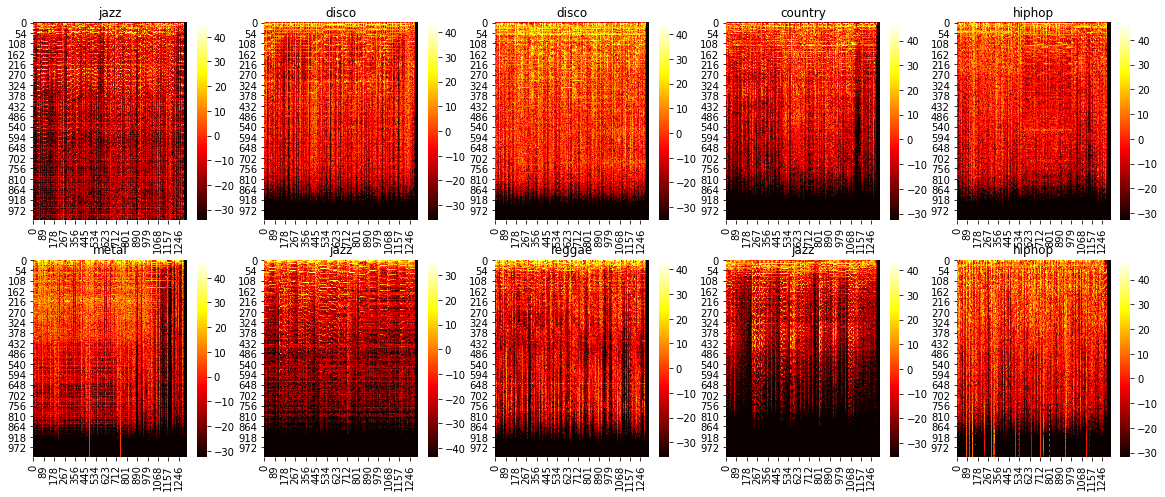

In [ ]:
import seaborn as sns
k = 0
fig, ax = plt.subplots(2, 5, figsize=(20, 8))

for i in range(2):
  for j in range(5):
    sns.heatmap(X[k], cmap='hot', ax=ax[i, j])
    ax[i, j].set_title(y_encoder.inverse_transform([Y[k]])[0])
    k += 1
plt.show()

# Neural Network

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)

In [ ]:
X = X / np.max(np.abs(X))

In [ ]:
INPUT_SHAPE[1:]

(1025, 1320)

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Input(shape=INPUT_SHAPE[1:]))

model.add(keras.layers.Conv1D(filters=16, kernel_size=3, activation='relu', padding='same'))
model.add(keras.layers.Conv1D(filters=16, kernel_size=3, activation='relu', padding='same'))
model.add(keras.layers.MaxPooling1D(pool_size=2))
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'))
model.add(keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'))
model.add(keras.layers.MaxPooling1D(pool_size=2))
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
model.add(keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
model.add(keras.layers.MaxPooling1D(pool_size=2))
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(units=512, activation='relu'))
model.add(keras.layers.Dense(units=512, activation='relu'))
model.add(keras.layers.Dense(units=10, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1025, 16)          63376     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1025, 16)          784       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 512, 16)           0         
_________________________________________________________________
dropout (Dropout)            (None, 512, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 512, 32)           1568      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 512, 32)           3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 256, 32)           0

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X, Y, epochs=100, validation_split=0.2)

Epoch 1/100
13/13 [==============================] - 2s 181ms/step - loss: 2.3928 - accuracy: 0.1375 - val_loss: 2.1543 - val_accuracy: 0.2600
Epoch 2/100
13/13 [==============================] - 1s 101ms/step - loss: 1.9905 - accuracy: 0.2500 - val_loss: 1.8513 - val_accuracy: 0.3400
Epoch 3/100
13/13 [==============================] - 1s 99ms/step - loss: 1.7726 - accuracy: 0.3450 - val_loss: 1.8684 - val_accuracy: 0.2900
Epoch 4/100
13/13 [==============================] - 1s 104ms/step - loss: 1.6816 - accuracy: 0.3800 - val_loss: 1.6638 - val_accuracy: 0.3800
Epoch 5/100
13/13 [==============================] - 1s 106ms/step - loss: 1.5154 - accuracy: 0.4700 - val_loss: 1.6569 - val_accuracy: 0.4200
Epoch 6/100
13/13 [==============================] - 1s 104ms/step - loss: 1.4305 - accuracy: 0.4825 - val_loss: 1.5857 - val_accuracy: 0.4500
Epoch 7/100
13/13 [==============================] - 1s 105ms/step - loss: 1.2908 - accuracy: 0.5550 - val_loss: 1.2989 - val_accuracy: 0.6200


Text(0.5, 1.0, '2D Fully Connected Network')

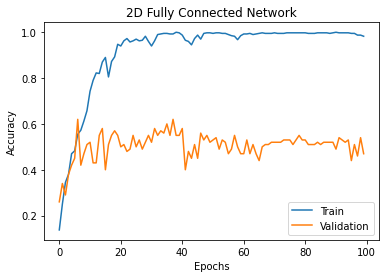

In [ ]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.title('2D Fully Connected Network')

In [ ]:
def prediction(filename):
  features, target = get_features_and_target(filename)
  features = librosa.amplitude_to_db(np.abs(librosa.stft( np.array(equal_length(features), dtype=np.float32)))) / 56
  pred = y_encoder.inverse_transform([np.argmax(model.predict(features.reshape((1, features.shape[0], features.shape[1]))))])
  return pred[0], target

In [ ]:
#model.save('/content/drive/MyDrive/Academics/Fall 2020/Intelligent Systems/Final Project/Models/model.h5')

In [ ]:
confusion_matrix = np.zeros((10, 10))
for i in range(500, 1000):
  print(i)
  y_test, y_true = prediction(filenames[i])
  y_test = y_encoder.transform([y_test])
  y_true = y_encoder.transform([y_true])
  confusion_matrix[y_test, y_true] += 1

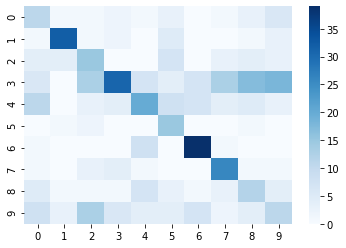

In [ ]:
sns.heatmap(confusion_matrix, cmap='Blues')